In [1]:
# Imports

from OverwatchProcessData import get_vector_herostats
from OverwatchProcessData import get_competitive_rank, hero_stats
from OverwatchGatherData import Player, find_usernames

import numpy as np
import os

np.random.seed(3)

from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout

import keras.backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Loading Data

specific_stats = {}

for stat in hero_stats:
    
    hero, _, _ = stat.split(" ")
    
    if hero in specific_stats:
        
        specific_stats[hero].append(stat)
    
    else:
        
        specific_stats[hero] = [stat]

def generate_players():
    
    for filename in os.listdir(os.path.join('..', 'profiles')):
        
        try: # If it can't read the player then just ignore file
            
            player = Player.from_file(os.path.join('..', 'profiles', filename))
        
            if 'error' not in player.json:

                yield player
                
        except:
            pass

def load_data(hero):

    unscaled_X, unscaled_y = [], []

    for player in generate_players():

        rank = get_competitive_rank(player, 'us')

        if rank:
            
            try:
                
                time_played = player.json['us']['heroes']['stats']['competitive'][hero]['general_stats']['time_played']
                
                if time_played >= .5:
                
                    unscaled_X.append(get_vector_herostats(player, 'us', stat_keys=specific_stats[hero]))
                    unscaled_y.append(rank)
                
            except:
                
                pass
           

    unscaled_X = np.array(unscaled_X, dtype=np.float64)
    unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
    print(unscaled_X.shape, unscaled_y.shape)
    
    return unscaled_X, unscaled_y

len(specific_stats), len(specific_stats['mercy'])

(26, 116)

In [3]:
# Scale

def scale_data(unscaled_X, unscaled_y):
    
    scaler_X = StandardScaler()

    X = scaler_X.fit_transform(unscaled_X)
    y = unscaled_y / 5000
    
    return X, y, scaler_X


In [4]:
# Metric

def acc_metric(y_true, y_pred):
    """
    Accuracy
    """
    diff = K.abs(y_pred - y_true) < .05 # Within 250 SR
    
    return K.mean(diff, axis=-1)


In [5]:
# Model

def get_model(hero):
    
    model = Sequential()
    
    model.add(Dense(30, input_dim=len(specific_stats[hero]), kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[acc_metric])
    
    return model


In [6]:
# Train wrapper

def train_model(model, *args, **kwargs):

    history = model.fit(*args, **kwargs, shuffle=True, validation_split=.10, verbose=0, callbacks=[EarlyStopping(patience=25)])
    
    return history

def get_hero_model(hero, from_file=False):
    
    if from_file:
        
        model = load_model(os.path.join('..', 'models', '{}-sr.h5'.format(hero)))
        
        scaler_X = joblib.load(os.path.join('..', 'models', '{}-sr.pkl'.format(hero)))
        
        return None, model, scaler_X
    
    X, y, scaler_X = scale_data(*load_data(hero))

    model = get_model(hero)

    history = train_model(model, X, y, epochs=1500, batch_size=128)

    model.save(os.path.join('..', 'models', '{}-sr.h5'.format(hero)))
    joblib.dump(scaler_X, os.path.join('..', 'models', '{}-sr.pkl'.format(hero)))
    
    return history, model, scaler_X


In [7]:
# Predict

def predict_sr(model, player, scaler_for_X, hero):
    
    stats_vector = np.array([get_vector_herostats(player, 'us', stat_keys=specific_stats[hero])])
    
    X = scaler_for_X.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(y_matrix) * 5000
    
    return int(sr)


In [8]:
# View

def view(history):
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('Log(loss)')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()


Training Genji
(2064, 96) (2064,)
Training Orisa
(2114, 93) (2114,)
Training Lucio
(3253, 114) (3253,)
Training Symmetra
(900, 97) (900,)
Training Roadhog
(3379, 111) (3379,)
Training Reinhardt
(3939, 98) (3939,)
Training Torbjorn
(813, 108) (813,)
Training Moira
(1974, 94) (1974,)
Training Widowmaker
(1416, 101) (1416,)
Training Mccree
(2738, 96) (2738,)
Training Pharah
(2749, 94) (2749,)
Training Tracer
(2246, 102) (2246,)
Training Soldier76
(3858, 114) (3858,)
Training Mei
(824, 108) (824,)
Training Zenyatta
(3344, 103) (3344,)
Training Mercy
(4533, 116) (4533,)
Training Winston
(3465, 110) (3465,)
Training Ana
(3377, 115) (3377,)
Training Dva
(3808, 109) (3808,)
Training Reaper
(2254, 99) (2254,)
Training Doomfist
(347, 87) (347,)
Training Bastion
(1031, 107) (1031,)
Training Zarya
(3540, 114) (3540,)
Training Junkrat
(2676, 97) (2676,)
Training Sombra
(467, 91) (467,)
Training Hanzo
(1312, 103) (1312,)


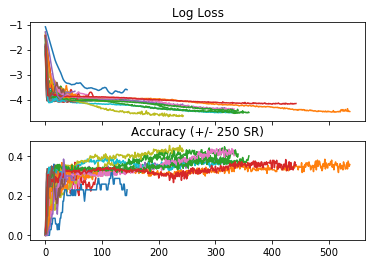

In [9]:
# Run

history_db = {}

f, (loss_plot, acc_plot) = plt.subplots(2, 1, sharex=True)

for hero in specific_stats:
    
    print('Training ' + hero.title())
    
    history, model, _ = get_hero_model(hero)
    
    loss, acc = np.log(history.history['val_loss']), history.history['val_acc_metric']
    
    loss_plot.plot(loss)
    acc_plot.plot(acc)
    
    history_db[hero] = [loss, acc]
    
loss_plot.set_title('Log Loss')
acc_plot.set_title('Accuracy (+/- 250 SR)')

plt.show()

In [ ]:
# Load models from disk

import keras.metrics
keras.metrics.acc_metric = acc_metric # Weird Patch

models = {}

for hero in specific_stats:
    
    models[hero] = get_hero_model(hero, from_file=True)


In [ ]:
# Predict using all viable models

def predict_all(player):
    
    sr_predictions = []
    time_played = []

    for hero in specific_stats:
        
        player_hero_stats = player.json['us']['heroes']['stats']['competitive']

        if hero in player_hero_stats and player_hero_stats[hero]['general_stats']['time_played'] >= .2:

            _, model, scaler = models[hero]
                
            sr_predictions.append(predict_sr(model, player, scaler, hero))
            time_played.append(player_hero_stats[hero]['general_stats']['time_played'])
                
    return int(np.average(sr_predictions, weights=time_played))


In [ ]:
# Test

with open('test_names.txt', 'r') as test:

    for battletag in find_usernames(test.read()):
        
        player = Player.from_web_battletag(battletag)
        
        actual = get_competitive_rank(player, 'us')
        p = predict_all(player)
        
        print("{} is {}, predicted {}".format(battletag, actual, p))
